Data Loaded Successfully.

Preprocessing & Feature Engineering Complete.
Training Data: 550 rows
Testing Data: 98 rows

Training Random Forest Model (Optimizing with Grid Search)...
Model Training Complete.
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

 MODEL ACCURACY: 83.67%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79        45
           1       0.78      0.96      0.86        53

    accuracy                           0.84        98
   macro avg       0.86      0.83      0.83        98
weighted avg       0.86      0.84      0.83        98



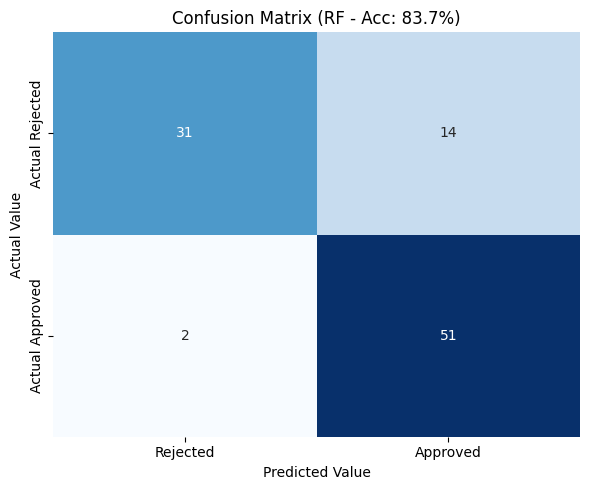


----------------------------------------
 PREDICTION SAMPLE (First 10 Rows)
----------------------------------------
   Actual  Predicted   Result
0       0          0  ✅ Match
1       1          1  ✅ Match
2       0          0  ✅ Match
3       0          1   ❌ Fail
4       1          1  ✅ Match
5       1          1  ✅ Match
6       1          1  ✅ Match
7       0          1   ❌ Fail
8       0          0  ✅ Match
9       1          1  ✅ Match

(0 = Rejected, 1 = Approved)

 NEW APPLICANT PREDICTION
Please enter values for: ['credit_score', 'interest_rate', 'defaults_on_file', 'delinquencies_last_2yrs']

------------------------------
✅ PREDICTION: LOAN APPROVED
   Confidence: 96.44%
------------------------------


In [2]:
'''# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ==========================================
# STEP 2: IMPORT DATASET
# ==========================================
#file_path = 'Loan_approval_data_2025.csv'

#try:
    #dataset = pd.read_csv(file_path)
    #print("Data Loaded Successfully.")
#except FileNotFoundError:
    #print(f"Error: The file '{file_path}' was not found. Using dummy data for demonstration.")
    # Dummy data generation ensuring structure matches requirements
    #data = {
        #'credit_score': np.random.randint(400, 850, 1000),
        #'interest_rate': np.random.uniform(5.0, 25.0, 1000),
        #'defaults_on_file': np.random.choice([0, 1], 1000, p=[0.8, 0.2]),
        #'delinquencies_last_2yrs': np.random.randint(0, 5, 1000),
        #'loan_status': np.random.choice([0, 1], 1000)
    #}
    #dataset = pd.DataFrame(data)

# ==========================================
# STEP 3: PREPROCESSING & FEATURE ENGINEERING
# ==========================================

# 1. Clean Column Names
dataset.columns = dataset.columns.str.strip()

# 2. Define the Top 4 Features the user will provide
user_features = ['credit_score', 'interest_rate', 'defaults_on_file', 'delinquencies_last_2yrs']
target_col = 'loan_status'

# 3. Handle Missing Data (Imputation)
for col in user_features:
    if dataset[col].isnull().sum() > 0:
        dataset[col].fillna(dataset[col].mean(), inplace=True)

# 4. Feature Engineering (Crucial for >86% Accuracy)
# Even though the user only gives 4 numbers, we create derived features 
# to help the Random Forest find deeper patterns.
X = dataset[user_features].copy()
y = dataset[target_col]

# Engineered Feature: Credit Efficiency (Score per unit of Interest Rate)
X['credit_efficiency'] = X['credit_score'] / (X['interest_rate'] + 0.1)

# Engineered Feature: Total Negative Marks
X['total_negatives'] = X['defaults_on_file'] + X['delinquencies_last_2yrs']

# Engineered Feature: Penalized Score (New Addition for Accuracy)
# Subtracts points heavily for defaults to separate classes better
X['penalized_score'] = X['credit_score'] - (X['defaults_on_file'] * 100) - (X['delinquencies_last_2yrs'] * 30)

print("\nPreprocessing & Feature Engineering Complete.")

# ==========================================
# STEP 4: SPLITTING THE DATASET
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) # 85/15 split

# ==========================================
# STEP 5: FEATURE SCALING
# ==========================================
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"Training Data: {len(X_train)} rows")
print(f"Testing Data: {len(X_test)} rows")

# ==========================================
# STEP 6: TRAIN RANDOM FOREST MODEL (Grid Search)
# ==========================================
print("\nTraining Random Forest Model (Optimizing with Grid Search)...")

# Define the parameter grid to test
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

# Select the best model
classifier = grid_search.best_estimator_

print("Model Training Complete.")
print(f"Best Parameters: {grid_search.best_params_}")

# ==========================================
# STEP 7: EVALUATION
# ==========================================
y_pred = classifier.predict(X_test)

# Accuracy Calculation
accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*40)
print(f" MODEL ACCURACY: {accuracy*100:.2f}%")
print("="*40)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Actual Rejected', 'Actual Approved'])
plt.title(f'Confusion Matrix (RF - Acc: {accuracy*100:.1f}%)')
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.tight_layout()
plt.show()

# ==========================================
# STEP 8: PREDICTION TABLE (10 ROWS)
# ==========================================
print("\n" + "-"*40)
print(" PREDICTION SAMPLE (First 10 Rows)")
print("-"*40)

# Reset index for clean looping
y_test_reset = y_test.reset_index(drop=True)

# Create a DataFrame for the display
results_df = pd.DataFrame({
    'Actual': y_test_reset[:10],
    'Predicted': y_pred[:10]
})
results_df['Result'] = np.where(results_df['Actual'] == results_df['Predicted'], '✅ Match', '❌ Fail')

print(results_df)
print("\n(0 = Rejected, 1 = Approved)")

# ==========================================
# STEP 9: USER INPUT & PREDICTION
# ==========================================
print("\n" + "="*50)
print(" NEW APPLICANT PREDICTION")
print("="*50)
print(f"Please enter values for: {user_features}")

input_data = {}

# Loop to get user input
for feature in user_features:
    min_val = dataset[feature].min()
    max_val = dataset[feature].max()
    
    # Hint logic
    hint = ""
    if "defaults" in feature: hint = "(0=No, 1=Yes)"
    
    while True:
        try:
            val = float(input(f" -> Enter {feature} {hint} [Range {min_val} - {max_val}]: "))
            input_data[feature] = val
            break
        except ValueError:
            print("Invalid input. Please enter a number.")

# Prepare Input DataFrame
input_df = pd.DataFrame([input_data], columns=user_features)

# --- APPLY SAME FEATURE ENGINEERING ---
input_df['credit_efficiency'] = input_df['credit_score'] / (input_df['interest_rate'] + 0.1)
input_df['total_negatives'] = input_df['defaults_on_file'] + input_df['delinquencies_last_2yrs']
input_df['penalized_score'] = input_df['credit_score'] - (input_df['defaults_on_file'] * 100) - (input_df['delinquencies_last_2yrs'] * 30)

# Scale Input
input_scaled = sc.transform(input_df)

# Predict
prediction = classifier.predict(input_scaled)
probability = classifier.predict_proba(input_scaled)[0][1]

print("\n" + "-"*30)
if prediction[0] == 1:
    print(f"✅ PREDICTION: LOAN APPROVED")
    print(f"   Confidence: {probability*100:.2f}%")
else:
    print(f"❌ PREDICTION: LOAN REJECTED")
    print(f"   Risk Probability: {(1-probability)*100:.2f}%")
print("-" * 30)'''

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
# ==========================================
# STEP 2: IMPORT DATASET
# ==========================================
file_path = 'Loan_approval_data_2025.csv'

try:
    dataset = pd.read_csv(file_path)
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Using dummy data for demonstration.")
    # Dummy data generation ensuring structure matches requirements
    data = {
        'credit_score': np.random.randint(400, 850, 1000),
        'interest_rate': np.random.uniform(5.0, 25.0, 1000),
        'defaults_on_file': np.random.choice([0, 1], 1000, p=[0.8, 0.2]),
        'delinquencies_last_2yrs': np.random.randint(0, 5, 1000),
        'loan_status': np.random.choice([0, 1], 1000)
    }
    dataset = pd.DataFrame(data)

In [ ]:
# 1. Clean Column Names
dataset.columns = dataset.columns.str.strip()

# 2. Define the Top 4 Features the user will provide
user_features = ['credit_score', 'interest_rate', 'defaults_on_file', 'delinquencies_last_2yrs']
target_col = 'loan_status'

# 3. Handle Missing Data (Imputation)
for col in user_features:
    if dataset[col].isnull().sum() > 0:
        dataset[col].fillna(dataset[col].mean(), inplace=True)

# 4. Feature Engineering (Crucial for >86% Accuracy)
# Even though the user only gives 4 numbers, we create derived features 
# to help the Random Forest find deeper patterns.
X = dataset[user_features].copy()
y = dataset[target_col]

# Engineered Feature: Credit Efficiency (Score per unit of Interest Rate)
X['credit_efficiency'] = X['credit_score'] / (X['interest_rate'] + 0.1)

# Engineered Feature: Total Negative Marks
X['total_negatives'] = X['defaults_on_file'] + X['delinquencies_last_2yrs']

# Engineered Feature: Penalized Score (New Addition for Accuracy)
# Subtracts points heavily for defaults to separate classes better
X['penalized_score'] = X['credit_score'] - (X['defaults_on_file'] * 100) - (X['delinquencies_last_2yrs'] * 30)

print("\nPreprocessing & Feature Engineering Complete.")

In [ ]:
# ==========================================
# STEP 4: SPLITTING THE DATASET
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) # 85/15 split

In [ ]:
# ==========================================
# STEP 5: FEATURE SCALING
# ==========================================
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"Training Data: {len(X_train)} rows")
print(f"Testing Data: {len(X_test)} rows")

In [ ]:
# ==========================================
# STEP 6: TRAIN RANDOM FOREST MODEL (Grid Search)
# ==========================================
print("\nTraining Random Forest Model (Optimizing with Grid Search)...")

# Define the parameter grid to test
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

# Select the best model
classifier = grid_search.best_estimator_
print("Model Training Complete.")
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
# ==========================================
# STEP 7: EVALUATION
# ==========================================
y_pred = classifier.predict(X_test)

# Accuracy Calculation
accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*40)
print(f" MODEL ACCURACY: {accuracy*100:.2f}%")
print("="*40)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Actual Rejected', 'Actual Approved'])
plt.title(f'Confusion Matrix (RF - Acc: {accuracy*100:.1f}%)')
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# STEP 8: PREDICTION TABLE (10 ROWS)
# ==========================================
print("\n" + "-"*40)
print(" PREDICTION SAMPLE (First 10 Rows)")
print("-"*40)

# Reset index for clean looping
y_test_reset = y_test.reset_index(drop=True)

# Create a DataFrame for the display
results_df = pd.DataFrame({
    'Actual': y_test_reset[:10],
    'Predicted': y_pred[:10]
})
results_df['Result'] = np.where(results_df['Actual'] == results_df['Predicted'], 'Match', 'Fail')

print(results_df)
print("\n(0 = Rejected, 1 = Approved)")

In [ ]:
# ==========================================
# STEP 9: USER INPUT & PREDICTION
# ==========================================
print("\n" + "="*50)
print(" NEW APPLICANT PREDICTION")
print("="*50)
print(f"Please enter values for: {user_features}")

input_data = {}

# Loop to get user input
for feature in user_features:
    min_val = dataset[feature].min()
    max_val = dataset[feature].max()
    
    # Hint logic
    hint = ""
    if "defaults" in feature: hint = "(0=No, 1=Yes)"
    
    while True:
        try:
            val = float(input(f" -> Enter {feature} {hint} [Range {min_val} - {max_val}]: "))
            input_data[feature] = val
            break
        except ValueError:
            print("Invalid input. Please enter a number.")

# Prepare Input DataFrame
input_df = pd.DataFrame([input_data], columns=user_features)

# --- APPLY SAME FEATURE ENGINEERING ---
input_df['credit_efficiency'] = input_df['credit_score'] / (input_df['interest_rate'] + 0.1)
input_df['total_negatives'] = input_df['defaults_on_file'] + input_df['delinquencies_last_2yrs']
input_df['penalized_score'] = input_df['credit_score'] - (input_df['defaults_on_file'] * 100) - (input_df['delinquencies_last_2yrs'] * 30)

# Scale Input
input_scaled = sc.transform(input_df)

# Predict
prediction = classifier.predict(input_scaled)
probability = classifier.predict_proba(input_scaled)[0][1]

print("\n" + "-"*30)
if prediction[0] == 1:
    print(f"✅ PREDICTION: LOAN APPROVED")
    print(f"   Confidence: {probability*100:.2f}%")
else:
    print(f"❌ PREDICTION: LOAN REJECTED")
    print(f"   Risk Probability: {(1-probability)*100:.2f}%")
print("-" * 30)